# TME 6 : Harris Corner Detector

The goal of this pratical work is to implement the Harris-Stephen's corners detector (C. Harris and M. Stephens. A combined corner and edge detector. In Proc. Fourth Alvey Vision Conference, pages 147–151, 1988).

Recall the Harris detector computes a map of corners from an image $I$:
$$
R(x,y) = \operatorname{det}(M) - k (\operatorname{trace}(M))^2, (x,y) \text{pixels}
$$
with $k\in[0.04, 0.06]$. $M$ is the auto-correlation of image $I$:
$$
M=\begin{pmatrix}
\sum_{x,y \in W} w(x,y)I_x^2 &
\sum_{x,y \in W} w(x,y)I_xI_y \\
\sum_{x,y \in W} w(x,y)I_xI_y &
\sum_{x,y \in W} w(x,y)I_y^2 
\end{pmatrix}
=\begin{pmatrix}
A & B \\ C & D
\end{pmatrix}
$$
with $w(x,y)=\frac1{2\pi \sigma^2}e^{\frac{(x-x_c)^2 + (y-y_c)^2}{2\sigma^2}}$ a Gaussian mask centered on the window $W$. Partial derivatives $I_x$ and $I_y$ are estimated by one of the following kernels :
- Gradient:  $G_x = \begin{pmatrix} 0 & 0 & 0\\ 1 & 0 &-1 \\ 0 & 0 & 0 \end{pmatrix}$,
 $G_y = G_x^T$
- Prewitt: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 1 & 0 &-1 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
- Sobel: $G_x = \begin{pmatrix} 1 & 0 & -1\\ 2 & 0 &-2 \\ 1 & 0 & -1 \end{pmatrix}$,
 $G_y = G_x^T$
 


In [8]:
# Loading useful libraries
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal
from scipy.signal import convolve2d

# remembering useful functions from last week
def SobelPhase1(I):
    # This one computes the gradient:
    sobelx = np.array([[1,0,-1],[2,0,-2],[1,0,-1]]) # predefined horizontal Sobel filter
    sobely = np.array([[1,2,1],[0,0,0],[-1,-2,-1]]) # predefined vertical Sobel filter
    horizontal = convolve2d(I,sobelx,mode='same') # mode = 'same' preserves the image's size by ignoring the padding
    vertical = convolve2d(I,sobely,mode='same') 
    gradient = np.sqrt(horizontal**2 + vertical**2)
    return horizontal, vertical, gradient

def SobelDetector(I,s):
    # This one applies a threshold on it:
    gradient = SobelPhase1(I)[2]
    edges = np.where(gradient>s,1,0) 
    return edges

def gaussianKernel(sigma):
    n = 2*np.ceil(3*sigma) + 1 # set an adequate window size
    x,y = np.meshgrid(np.arange(-n//2,n//2),np.arange(-n//2,n//2))
    return np.exp((-x**2-y**2)/(2*sigma*sigma))

def imshow(I, title=None, size=500, axis=False):
    plt.figure(figsize=(size//80, size//80))
    plt.gray()
    plt.imshow(I)
    if not axis: plt.axis('off')
    if title: plt.title(title)
    plt.show()
    
def niceDisplay14(affichages,titres=None):
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('niceDisplay_14 : affichage should be a list of length 1 up to 4')
    if nb_affichages != len(titres):
        raise ValueError('niceDisplay_14 : titres must have same length than affichage')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = plt.subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plt.plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = plt.gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    plt.show()
    
def imagePad(I,n): # custom padding
    image = I.copy()
    image = np.pad(image,n,'constant')
    return image

## Exercise 1: Harris response calculation

1) Write a function `computeR(I,sigma,kappa)` that returns the Harris response $R$ from an image $I$ and a scale $scale$. You will use 5 steps:
- Computation of the directionnal derivate $I_x$ and $I_y$. Use the Sobel kernel.
- Computation of the products $I_x^2$, $I_y^2$, $I_x.I_y$.
- Computation of the convolution of $I_x^2$, $I_y^2$ and $I_x.I_y$ by a gaussian kernel of size N (use given function `gaussian_kernel3()`)
- Computation of $\operatorname{det}(M(x,y))$ and $\operatorname{trace}(M(x,y))$ for each pixel
- Computation of $R(x,y) = \operatorname{det}(M(x,y)) - k.(\operatorname{trace}(M(x,y)))^2$. You can use $k = 0.04$.

 You can compute the convolutions by using the ```scipy.signal.convolve2d``` function. 


In [5]:
def computeR(I,sigma,kappa):
    # directional derivates
    Ix, Iy, grad = SobelPhase1(I)
    # convolve with a Gaussian kernel
    gk = gaussianKernel(sigma)
    gIx_pow2 = convolve2d(Ix**2, gk, mode='same') 
    gIy_pow2 = convolve2d(Iy**2, gk, mode='same') 
    gIxy = convolve2d(Ix*Iy, gk, mode='same') 
    # det(gI) = ad - bc
    detgI = gIx_pow2 * gIy_pow2 - gIxy**2 
    # trace(gI) = a + d
    tracegI = gIx_pow2 + gIy_pow2
    return detgI - kappa * tracegI**2

2) Write a script that displays the Harris response for the image ```img/house2.png``` along with the original image. Use a gaussian window of size $W=15$ pixels.

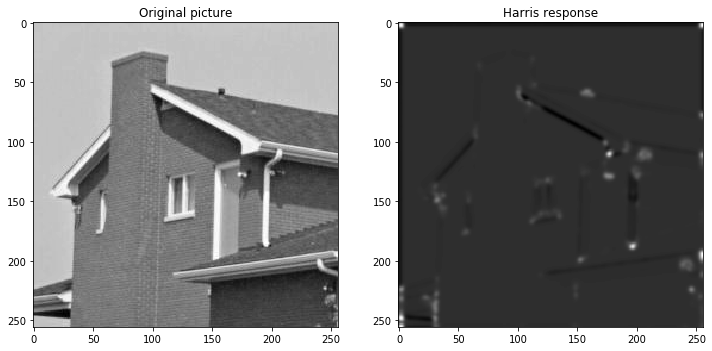

In [40]:
imageHouse = np.array(Image.open('img/house2.png'))
# a sigma = 2.1 parameter yields a Gaussian window of size 15 
# setting kappa to 0.04 for best results
cornHouse = computeR(imageHouse,2.1,0.04) 
niceDisplay14([imageHouse,cornHouse],["Original picture","Harris response"])

3) Write in a few lines an interpretation of the results, explaining how the Harris response allows to detect and discriminate homogeneous areas, edges and corners.

The Harris detector just maps a non-significant value (≈127-grey) onto homogenous areas, whereas edges are shown with a negative hue (≈0). The most important data are the corner locations, that are punctually emphasized in white (≈255).  
It is worth mentioning the outliers that loom on the corners of the display field. These are linked to the zero-padding policy used to convolve the filters with the original image. The strong gradients between the artificial null values and the sky's light surface are misinterpreted as additional edges around the display field, and Harris' algorithm states that edge intersections shall always be recognised as corners.  
Choosing a mirror-padding policy instead would solve the problem.  
The nice part is that no false detections were made apart from that.

## Exercise 2 : Harris corner detector
From the Harris response calculated at exercise 1, we will write all the functions needed for the Harris detector. Write the following functions: 

1) A function `thresholdR(R, thres)` that calculates and returns the binary thresholding $R_b$ of the response $R$ according to the threshold $thres$

In [12]:
def thresholdR(R, thres):
    return np.where(R>thres, 1, 0)

2) A function `Rnms(R, Rbin)` that performs a non-maximum suppression from the response $R$ and the binarized response $R_{bin}$. It returns the image $R_{locmax}$ (same size as $R$) =1 where $R_{bin}=1$ and the pixel has a greater $R$ value than its 4 nearest neighbors.

**Bonus**: Write a faster version of the script using Numpy function `np.roll()`.

In [32]:
def RnmsSlow(R, Rbin):
    Rlocmax = np.zeros(R.shape)
    # neighbourhood operations ↔ padding required
    Rp = imagePad(R,1)
    for x in range(R.shape[0]):
        for y in range(R.shape[1]):
            if Rbin[x,y] == 1 and R[x,y] > np.max([Rp[x,y+1],Rp[x+2,y+1],Rp[x+1,y],Rp[x+1,y+2]]):
                                            # testing the four neighbours on the padded image
                    Rlocmax[x,y] = 1
    return Rlocmax

In [34]:
def RnmsSpeed(R, Rbin):
    # computing 1-px shifts in all four directions
    Rb = np.roll(R,1,axis=0)
    Rt = np.roll(R,-1,axis=0)
    Rl = np.roll(R,1,axis=1)
    Rr = np.roll(R,-1,axis=1)
    # generating True-False matrices...
    Mb = R>Rb
    Mt = R>Rt
    Ml = R>Rl
    Mr = R>Rr
    Mbin = Rbin==1
    # ...that will all read "True" on certain locations - in case there is something to highlight there
    M = Mb & Mt & Ml & Mr & Mbin
    return np.where(M==True, 1, 0) # bool. to {0,1} mapping

3) Write a function ``cornerDetector(image, sigma, kappa, thresh)`` that returns an array of the same size as the image. The array takes two values: 1 where a corner is detected and 0 elsewhere.

In [29]:
def cornerDetector(image, sigma, kappa, thres):
    R = computeR(image,sigma,kappa)
    Rbin = thresholdR(R,thres)
    # imshow(Rbin) # debug
    # Rlocmax = RnmsSlow(R,Rbin) # same result anyway
    Rlocmax = RnmsSpeed(R,Rbin)
    return Rlocmax

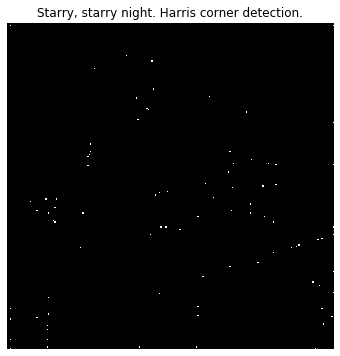

In [67]:
harrisHouse = cornerDetector(imageHouse,2.1,0.04,10E+9)
imshow(harrisHouse,"Starry, starry night. Harris corner detection.")

4 ) Display the detected corners on the original image for the image ```img/house2.png```. Each detected corner will be displayed as a small red disk. You can use the functions ```np.nonzero()``` and ```plt.scatter()``` to that purpose.

In [68]:
def showCorners(image, harris):
    y,x = np.nonzero(harris)
    # voir les choses en grand
    plt.figure(figsize = (10,10))
    plt.imshow(image)
    plt.scatter(x, y, c='red', marker='o')
    plt.show()

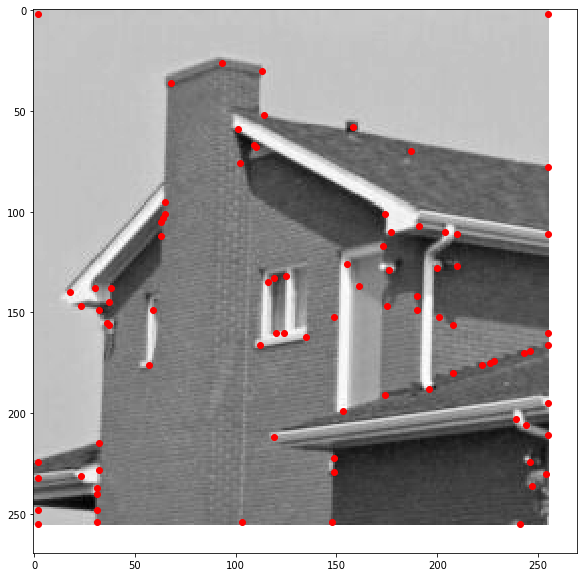

In [69]:
showCorners(imageHouse,harrisHouse)

5) Evaluate the performances of the corner detector. Try to find good values for Sigma and Threshold.

As $\kappa$ is conventionnally set at 0.04, we just had to find optimal values for the other parameters, $\sigma$ and "thresh".  

$\sigma$ represents the parameter of the Gaussian distribution. The higher it gets, the broader the window.  
Empirical tests proved that $\sigma$ did its best job when set at 2.1 while the window's size was 15. Solving 15 = 2\*ceil(3*$\sigma$)+1 yields the same result.  
On the other hand, setting the threshold at $10^9$ allows the detection of most corners while not highlighting anything else. We noticed that choosing a higher threshold means losing data - and choosing a lower threshold means drowning the relevant message under false detections. It is all about finding a satisfying tradeoff.

Delighted with the absence of false detections, we regrettably have to accept that some less evident corners will always be missing.  
On the original image, the upper corners of the windows seem to fade in the wall - it is a matter of lighting. We, humans, are able to see them as such, for we know that a window must be square ; but the detector fails to find a difference between the bricks' and the upper lintels' colour intensities.  
This means that no edges were detected there, hence no corners.  
This example, amongst others, shows the limits of the Harris corner detector. Since it relies on edge detection, it has the exact same drawbacks - it doesn't react to slow intensity changes. Sharpening the picture's contrast might help.

## Exercise 3 : Properties of the Harris corner detector

The goal of this exercise is to study some invariance properties of the Harris detector.

1) Write a script that detects the corners on the images ```img/toyHorse1.png``` and ```img/toyHorse2.png``` with a scale of 15 and an appropriate threshold value. Display the detected corners on the images.

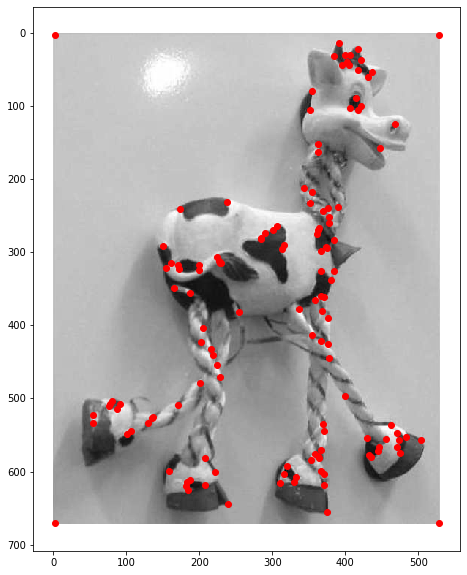

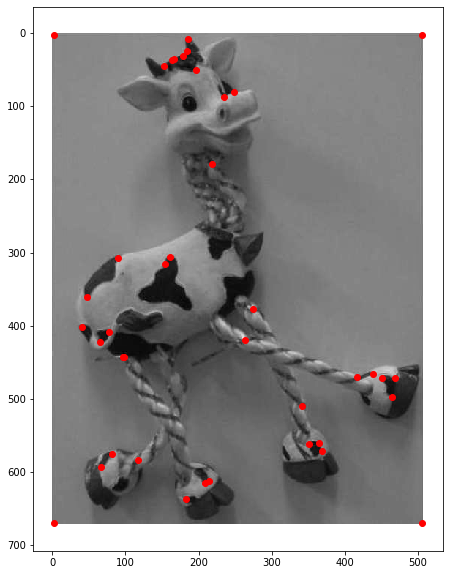

In [76]:
imageGiraffe1 = np.array(Image.open('img/toyHorse1.png'))
# !!
imageGiraffe2 = np.array(Image.open('img/toyHorse2.png'))
harrisGiraffe1 = cornerDetector(imageGiraffe1,2.1,0.04,10E+10)
showCorners(imageGiraffe1,harrisGiraffe1)
harrisGiraffe2 = cornerDetector(imageGiraffe2,2.1,0.04,10E+10)
showCorners(imageGiraffe2,harrisGiraffe2)

2) What are the dynamic ranges of these two images ?

In [78]:
range1 = np.amax(imageGiraffe1)-np.amin(imageGiraffe1)
range2 = np.amax(imageGiraffe2)-np.amin(imageGiraffe2)
print(range1, range2)

254 253


These images cover comparable dynamic ranges. At least one pixel in each has a ≈0-black value - and another has a ≈255-white/off-white value. Speaking of powers of 2, it means that both images were coded on a [0,256[ range.  
The human eye nevertheless notices that the second image is globally restricted to a small fraction of said range, since all the hues in it converge towards some kind of tedious grey.

3) What are the transformations beetween the two images ?

As compared to its first presentation, the **_object_** in the second picture underwent rotation. The portrait was then shot with a brightness change.   

4) Using a fixed threshold, is the detection invariant to rotation ? To affine transformation of brightness ?

We claimed, two hours ago, that the Harris corner detector was theoretically invariant to rotation. Does this application proves us wrong ?..  
It is not the picture that was rotated, but the real object shown in it. In other words, there is no way of obtaining the initial picture after applying a numerical counterrotation. So, this example is irrelevant as for judging the detector's performance.  
Notice that the affine brightness change actually lessens its ability to find the corners. The contrast is weaker (cf. TME5), which means that the edges are less sharp, and so are their intersections.